In [3]:
from IPython.core.debugger import Tracer

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
import argparse
from datetime import datetime
import os
import time
import multiprocessing
import psutil
import json
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  
import h5py
from sklearn.model_selection import train_test_split
from skimage.util import crop,  random_noise
from skimage.transform import   rescale, resize, rotate, AffineTransform, warp
import torch.optim as optim
from tqdm import tqdm
from resnet18 import resnet18
from collections import Counter

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64
num_epochs = 10

this limitation is particular to the current implementation and essentially because intermediate activations for both baselines and inputs need to be stored in the forward pass and used to override the gradient in the backward pass. Currently, those activations are stored as (temporary) attributes on the corresponding modules themselves, so a reused activation causes overwriting the stored temporary attributes. (A similar issue also indirectly affects layer and neuron attribution methods in Captum, they always attribute with respect to the last execution of a reused module.)

In most cases, we may be able to get around this issue with refactoring the implementation to allow storing multiple activations for a single module by keying on the execution count, essentially by separately storing the activations for the 1st, 2nd, 3rd, etc. time the module is executed. We haven't yet worked on this refactor, but we will consider if we can prioritize it for future releases if this is a common issue.

In [4]:
h5_file = "data/WBC/Lyse fix sample_1_Focused & Singlets & CD45 pos.h5"

In [5]:
from dataset import Dataset_Generator, train_validation_test_split, get_classes_map, number_of_classes, number_of_channels

In [6]:
data = h5py.File(h5_file, "r")
label_map = data.get("label_map")[()]

In [7]:
Counter(data.get("labels")[()])

Counter({1: 4476,
         2: 1788,
         3: 18325,
         5: 889,
         4: 1282,
         0: 1286,
         8: 1537,
         6: 669,
         7: 1028})

In [8]:
label_map

"{0: ' unknown', 1: ' CD4+ T', 2: ' CD8+ T', 3: ' CD15+ neutrophil', 4: ' CD14+ monocyte', 5: ' CD19+ B', 6: ' CD56+ NK', 7: ' NKT', 8: ' eosinophil'}"

data = h5py.File(h5_file, "r") 
image_original = data.get(str(21043) + "_image")[()]
h, w = crop_pad_h_w(image_original, 64)
h1_crop, h2_crop, h1_pad, h2_pad =  h 
w1_crop, w2_crop, w1_pad, w2_pad = w 
image = np.zeros((12 , 64, 64), dtype = np.float64)
for ch in range(image_original.shape[2]): 
        image_dummy = crop(image_original[:,:,ch], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
        image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), "edge" )
        image[ch,:,:] = image_dummy
image = torch.from_numpy(image.copy())

In [9]:
train_indx, validation_indx, test_indx = train_validation_test_split(h5_file)

In [10]:
test_indx

array([ 8475, 20840,  8499, ..., 21813, 27143,  8679], dtype=int32)

In [11]:
transform = transforms.Compose(
    [transforms.RandomVerticalFlip(),
     transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45)])

In [13]:
train_dataset =  Dataset_Generator(h5_file , train_indx, reshape_size = 64, transform=transform)

In [14]:
trainloader = DataLoader( train_dataset, 
                                batch_size= batch_size, 
                                shuffle=False, 
                                num_workers=2)

3


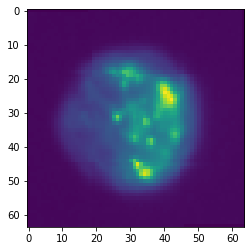

In [16]:
print(train_dataset[0]["label"].numpy()[0])
plt.imshow(train_dataset[0]["image"][1,:,:])

mean_per_channel = []
stds_per_channel = []
for data in trainloader:
    indx = (data["object_number"] != -1).reshape(-1)
    if indx.sum() > 0:
        inputs = data["image"][indx]
        inputs = inputs.to(device)
        inputs = inputs.float()
        mean_per_channel.append(inputs.mean(dim=(2,3)).sum(0))
        stds_per_channel.append(inputs.std(dim=(2,3)).sum(0))
means = torch.sum(torch.stack(mean_per_channel, axis=0), dim=0) / len(train_dataset)
stds = torch.sum(torch.stack(stds_per_channel, axis=0), dim=0) / len(train_dataset)

numer_of_channels = 12    

statistics = dict()
#statistics["min"] = torch.zeros(numer_of_channels) + np.power(2,16) # 16-bit images
statistics["mean"] = torch.zeros(numer_of_channels)
statistics["std"] = torch.zeros(numer_of_channels)
#statistics["max"] = torch.zeros(numer_of_channels)


for j, data in enumerate(trainloader, 1): 

    data = data["image"] 
    for i in range(numer_of_channels):
        #statistics["min"][i] = min(data[:,i,:,:].min(), statistics["min"][i])
        statistics["mean"][i] += data[:,i,:,:].mean()
        statistics["std"][i] += data[:,i,:,:].std()
        #statistics["max"][i] = max(data[:,i,:,:].max(), statistics["max"][i])
train_dataset =  Dataset_Generator(h5_file , train_indx, reshape_size = 64, transform=transform, means=statistics["mean"].div_(len(trainloader)), stds=statistics["std"].div_(len(trainloader))) 

In [12]:
statistics= {'mean': torch.tensor([304.2655,   9.8241,  22.6823,   8.7255,  11.8348,  21.6108,  24.2642,
         20.3928, 297.5275,  21.1994,   9.0133,  13.9198]), 'std': torch.tensor([111.9069,  13.5661,   8.3949,   3.7693,   4.4474,  23.4048,  21.6134,
         16.3013, 109.4360,   8.6366,   3.8256,   5.8184])}

In [13]:
trainloader_len = 1755

In [14]:
train_dataset =  Dataset_Generator(h5_file , train_indx, reshape_size = 64, transform=transform, means=statistics["mean"].div_(trainloader_len),
                                     stds=statistics["std"].div_(trainloader_len)) 
validation_dataset =  Dataset_Generator(h5_file , validation_indx, reshape_size = 64, means=statistics["mean"].div_(trainloader_len),
                                     stds=statistics["std"].div_(trainloader_len))

test_dataset = Dataset_Generator(h5_file, test_indx, reshape_size=64,
                                     means=statistics["mean"].div_(trainloader_len),
                                     stds=statistics["std"].div_(trainloader_len))

In [15]:
trainloader = DataLoader( train_dataset, 
                                batch_size= batch_size, 
                                shuffle=False, 
                                num_workers=2)
validationloader = DataLoader( validation_dataset, 
                                batch_size= batch_size, 
                                shuffle=False, 
                                num_workers=1)
testloader = DataLoader( test_dataset, 
                                batch_size= batch_size, 
                                shuffle=False, 
                                num_workers=1)

In [19]:
def plot_heatmap_12_channels(heatmap):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(15,15))
    #plt.figure(figsize=(20,10))
    ax1.imshow(heatmap[0])
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2.imshow(heatmap[1])
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)
    ax3.imshow(heatmap[2])
    ax3.axes.get_xaxis().set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)

    ax4.imshow(heatmap[3])
    ax4.axes.get_xaxis().set_visible(False)
    ax4.axes.get_yaxis().set_visible(False)
    ax5.imshow(heatmap[4])
    ax5.axes.get_xaxis().set_visible(False)
    ax5.axes.get_yaxis().set_visible(False)
    ax6.imshow(heatmap[5])
    ax6.axes.get_xaxis().set_visible(False)
    ax6.axes.get_yaxis().set_visible(False)

    ax7.imshow(heatmap[6])
    ax7.axes.get_xaxis().set_visible(False)
    ax7.axes.get_yaxis().set_visible(False)
    ax8.imshow(heatmap[7])
    ax8.axes.get_xaxis().set_visible(False)
    ax8.axes.get_yaxis().set_visible(False)
    ax9.imshow(heatmap[8])
    ax9.axes.get_xaxis().set_visible(False)
    ax9.axes.get_yaxis().set_visible(False)

    ax10.imshow(heatmap[9])
    ax10.axes.get_xaxis().set_visible(False)
    ax10.axes.get_yaxis().set_visible(False)
    ax11.imshow(heatmap[10])
    ax11.axes.get_xaxis().set_visible(False)
    ax11.axes.get_yaxis().set_visible(False)
    ax12.imshow(heatmap[11])
    ax12.axes.get_xaxis().set_visible(False)
    ax12.axes.get_yaxis().set_visible(False)

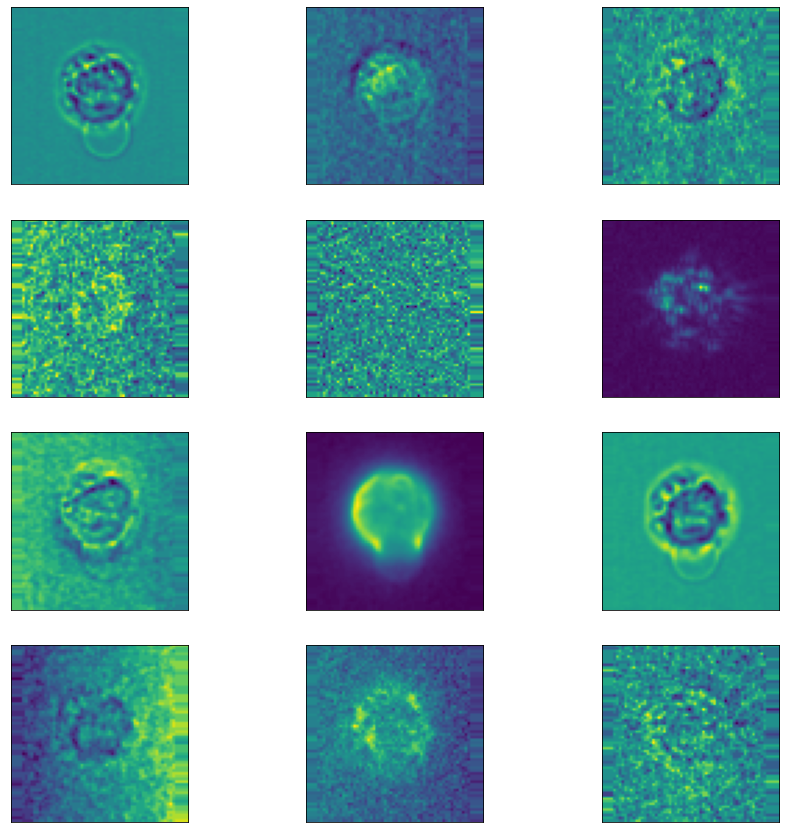

In [20]:
plot_heatmap_12_channels(test_dataset[0]["image"])

3


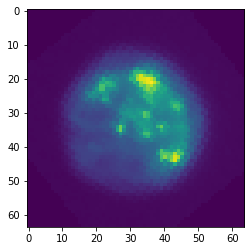

In [34]:
print(train_dataset[0]["label"].numpy()[0])
plt.imshow(train_dataset[0]["image"][1,:,:])

data_dir = "/home/aleksandra/PycharmProjects/interpretable-multichannel-image-analysis/data/WBC/PreprocessedTestData"
for i,x in zip(np.arange(len(test_dataset)), test_dataset):
    #Tracer()()
    torch.save((x['image'],int(x['label'])), os.path.join(data_dir, 'test_sample_{}.pt'.format(i)))
print("All test Data preprocessed and saved")

1


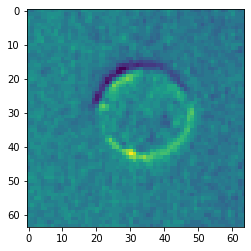

In [35]:
print(test_dataset[2]["label"].numpy()[0] )
plt.imshow(test_dataset[2]["image"][1,:,:])

In [21]:
num_classes = number_of_classes(h5_file)
num_channels = number_of_channels(h5_file)

In [22]:
import ast

In [23]:
label_map = ast.literal_eval(label_map)

In [24]:
class_names = list(label_map.values())

In [35]:
class_names

[' unknown',
 ' CD4+ T',
 ' CD8+ T',
 ' CD15+ neutrophil',
 ' CD14+ monocyte',
 ' CD19+ B',
 ' CD56+ NK',
 ' NKT',
 ' eosinophil']

model = resnet18(pretrained=True)
## loading the imagenet weights in case it is possible
if num_channels != 3:
    model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=(7, 7), 
                            stride=(2, 2), padding=(3, 3), bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    print("epoch", epoch)
    for i, data in enumerate(trainloader, 0): 
        
        # get the inputs; data is a list of [inputs, labels]
        indx = (data["object_number"] != -1).reshape(-1)
        if indx.sum() > 0:
            inputs, labels = data["image"][indx], data["label"][indx]

            inputs, labels = inputs.to(device), labels.to(device)     
            inputs = inputs.float()
            labels = labels.reshape(-1)


            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs) 
            _ , predicted = torch.max(outputs.data, 1) 


            loss = criterion(outputs, F.one_hot(labels.long(), num_classes ).type_as(outputs))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        if i % 500 == 499:    # print every 2000 mini-batches
            print('[%d, %5d] training loss: %.8f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(validationloader, 0):
            indx = (data["object_number"] != -1).reshape(-1)
            if indx.sum() > 0:
                inputs, labels = data["image"][indx], data["label"][indx]

                inputs, labels = inputs.to(device), labels.to(device)     
                inputs = inputs.float()
                labels = labels.reshape(-1)

                outputs = model(inputs)
                _ , predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (labels.reshape(-1) == predicted).sum().item()

    print('Accuracy of the network on the %d validation images: %d %%' % (len(validation_dataset), 100 * correct / total))#
        
print('Finished Training')

torch.save(model.state_dict(), "models/final_model_normalized_state_dict.pth")

In [25]:
model = resnet18(pretrained=True)
## loading the imagenet weights in case it is possible
if num_channels != 3:
    model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=(7, 7), 
                            stride=(2, 2), padding=(3, 3), bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
model = model.to(device)
model.load_state_dict(torch.load('models/final_model_dict_wbc_all.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [42]:
correct = 0.
total = 0.

with torch.no_grad():
    for data in testloader:
        indx = (data["object_number"] != -1).reshape(-1)
        if indx.sum() > 0:
            inputs, labels = data["image"][indx], data["label"][indx]

            inputs, labels = inputs.to(device), labels.to(device)     
            inputs = inputs.float()
            labels = labels.reshape(-1)

            outputs = model(inputs)
            _ , predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (labels.reshape(-1) == predicted).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (len(test_dataset),
    100 * correct / total))

Accuracy of the network on the 6256 test images: 97 %


In [27]:
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for data in testloader:
        indx = (data["object_number"] != -1).reshape(-1)
        if indx.sum() > 0:
            inputs, labels = data["image"][indx], data["label"][indx]
            inputs, labels = inputs.to(device), labels.to(device)     
            inputs = inputs.float()
            labels = labels.reshape(-1)

            pred = model(inputs).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(labels[i].item())
                y_pred.append(pred[i].item())

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

                   precision    recall  f1-score   support

          unknown     0.9181    0.8288    0.8712       257
           CD4+ T     0.9856    0.9911    0.9883       895
           CD8+ T     0.9691    0.8771    0.9208       358
 CD15+ neutrophil     0.9986    1.0000    0.9993      3665
   CD14+ monocyte     0.9843    0.9805    0.9824       256
          CD19+ B     0.9727    1.0000    0.9861       178
         CD56+ NK     0.9851    0.9851    0.9851       134
              NKT     0.7649    0.9320    0.8403       206
       eosinophil     1.0000    1.0000    1.0000       307

         accuracy                         0.9813      6256
        macro avg     0.9532    0.9549    0.9526      6256
     weighted avg     0.9825    0.9813    0.9814      6256



In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, caption=""):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix ' + caption
        else:
            title = 'Confusion matrix, without normalization ' + caption

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix" + caption)
    else:
        print('Confusion matrix, without normalization' + caption)

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    #fig.savefig("CM_WBC_all.png")
    return ax

Normalized confusion matrix
[[0.82879377 0.0155642  0.03501946 0.0155642  0.01167315 0.01945525
  0.0077821  0.06614786 0.        ]
 [0.00782123 0.99106145 0.         0.         0.         0.
  0.         0.00111732 0.        ]
 [0.00558659 0.         0.87709497 0.0027933  0.         0.
  0.         0.11452514 0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.01953125 0.         0.         0.         0.98046875 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.        ]
 [0.00746269 0.         0.         0.         0.00746269 0.
  0.98507463 0.         0.        ]
 [0.01941748 0.04368932 0.00485437 0.         0.         0.
  0.         0.93203883 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.        ]]


<AxesSubplot:title={'center':'Normalized confusion matrix '}, xlabel='Predicted label', ylabel='True label'>

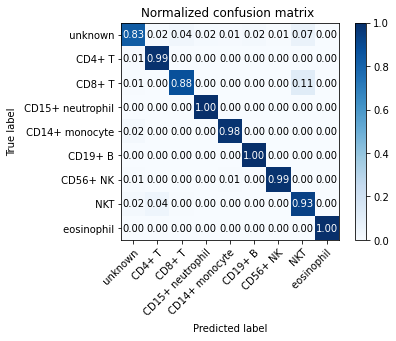

In [34]:
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True)

In [84]:
from captum.attr import LayerAttribution, IntegratedGradients, GuidedGradCam, DeepLift, Saliency, DeepLiftShap, GradientShap, InputXGradient, GuidedBackprop, GuidedGradCam, Deconvolution, LayerGradCam

In [29]:
from collections.abc import Sequence
from functools import partial
from typing import Optional, Union

import numpy as np
import torch
import torch.nn as nn

softmax = nn.Softmax(dim=1)

try:
    from tqdm import trange

    trange = partial(trange, desc="Computing occlusion sensitivity")
except (ImportError, AttributeError):
    trange = range
    

def _append_to_sensitivity_im(model, batch_images, batch_ids, sensitivity_im):
    """For given number of images, get probability of predicting
    a given label. Append to previous evaluations."""
    batch_images = torch.cat(batch_images, dim=0)
    batch_ids = torch.LongTensor(batch_ids).unsqueeze(1).to(sensitivity_im.device)
    scores = model(batch_images).detach().gather(1, batch_ids)
    #Tracer()()
    return torch.cat((sensitivity_im, scores))

def compute_occlusion_sensitivity_debug_per_channel_custom(
    model: nn.Module,
    image: torch.Tensor,
    label: Union[int, torch.Tensor],
    pad_val: float = 0.0,
    margin: Union[int, Sequence] = 2,
    n_batch: int = 128,
    stride: Union[int, Sequence] = 1,
    upsample_mode: str = "nearest",
    threshold: float = 0.0
) -> np.ndarray:

    im_shape = np.array(image.shape[1:])

    # Get baseline probability
    baseline = model(image).detach()[0, label].item()
    
    #image = image.T

    # Create some lists
    batch_images = []
    batch_ids = []

    sensitivity_im = torch.empty(0, dtype=torch.float32, device=image.device)
    
    # If no bounding box supplied, output shape is same as input shape.
    # If bounding box is present, shape is max - min + 1
    output_im_shape = im_shape

    # Calculate the downsampled shape
    if not isinstance(stride, Sequence):
        stride_np = np.full_like(im_shape, stride, dtype=np.int32)
        stride_np[0] = 1  # always do stride 1 in channel dimension
    else:
        # Convert to numpy array and check dimensions match
        stride_np = np.array(stride, dtype=np.int32)
        if stride_np.size != im_shape.size:
            raise ValueError("Sizes of image shape and stride should match.")

    # Obviously if stride = 1, downsampled_im_shape == output_im_shape
    downsampled_im_shape = np.floor(output_im_shape / stride_np).astype(np.int32)
    downsampled_im_shape[downsampled_im_shape == 0] = 1  # make sure dimension sizes are >= 1
    num_required_predictions = np.prod(downsampled_im_shape)
    
    for layer in range(12):
        for i in trange(int(num_required_predictions / 12)):
            channel = image[0][layer].clone()
            #Tracer()()
            stride_np = np.full_like(channel.shape, stride, dtype=np.int32)
            stride_np[0] = 1
            #C
            # Get corresponding ND index
            idx = np.unravel_index(i, downsampled_im_shape[1:])
    
            # Multiply by stride
            idx *= stride_np
                
            # Get min and max index of box to occlude
            min_idx = [max(0, i - margin) for i in idx]
            max_idx = [min(j, i + margin) for i, j in zip(idx, channel.shape)]
            #Tracer()()

            # Clone and replace target area with `pad_val`
            occlu_im = image.clone()
            #Tracer()()
            channel[min_idx[0]:max_idx[0],min_idx[1]:max_idx[1]] = pad_val
            #channel[(...,) + tuple(slice(i, j) for i, j in zip(min_idx, max_idx))] = pad_val
            occlu_im[0][layer] = channel
            #plt.imshow(occlu_im[0].T)
            #Tracer()()

            # Add to list
            #batch_images.append(occlu_im.T)
            batch_images.append(occlu_im)
            batch_ids.append(label)
            if len(batch_images) == n_batch or i == int(num_required_predictions / 12) - 1:
            # Do the predictions and append to sensitivity map
                sensitivity_im = _append_to_sensitivity_im(model, batch_images, batch_ids, sensitivity_im)
                # Clear lists
                #Tracer()()
                batch_images = []
                batch_ids = []
    #Tracer()()
    # Subtract from baseline
    sensitivity_im = baseline - sensitivity_im

    # Reshape to match downsampled image
    sensitivity_im = np.where(sensitivity_im<threshold, 0, sensitivity_im)
    #Tracer()()
    sensitivity_im = sensitivity_im.reshape(tuple(downsampled_im_shape))

    # If necessary, upsample
    if np.any(stride_np != 1):
        output_im_shape = tuple(output_im_shape[1:])  # needs to be given as 3D tuple
        upsampler = nn.Upsample(size=output_im_shape, mode=upsample_mode)
        sensitivity_im = upsampler(sensitivity_im.unsqueeze(0))

    # Convert tensor to numpy
    #sensitivity_im = sensitivity_im.cpu().numpy()
    #sensitivity_im = (sensitivity_im - np.min(sensitivity_im)) / (np.max(sensitivity_im) - np.min(sensitivity_im))
    #Tracer()()
    # Squeeze and return
    return np.squeeze(sensitivity_im)

In [31]:
def plot_heatmap_12_channels_hist(heatmap):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(15,15))
    #plt.figure(figsize=(20,10))
    ax1.hist(heatmap[0].ravel(), bins = 50)
    ax2.hist(heatmap[1].ravel(), bins = 50)
    ax3.hist(heatmap[2].ravel(), bins = 50)

    ax4.hist(heatmap[3].ravel(), bins = 50)
    ax5.hist(heatmap[4].ravel(), bins = 50)
    ax6.hist(heatmap[5].ravel(), bins = 50)

    ax7.hist(heatmap[6].ravel(), bins = 50)
    ax8.hist(heatmap[7].ravel(), bins = 50)
    ax9.hist(heatmap[8].ravel(), bins = 50)

    ax10.hist(heatmap[9].ravel(), bins = 50)
    ax11.hist(heatmap[10].ravel(), bins = 50)
    ax12.hist(heatmap[11].ravel(), bins = 50)

In [78]:
occlusion_custom = compute_occlusion_sensitivity_debug_per_channel_custom(model, test_dataset[2]["image"].reshape((1,12,64,64)).float(), test_dataset[2]["label"].numpy()[0], margin=4)

Computing occlusion sensitivity: 100%|██████████| 4096/4096 [00:16<00:00, 389.49it/s]


In [36]:
(occlusion_custom.max() - occlusion_custom.min()) /2

4.866371154785156

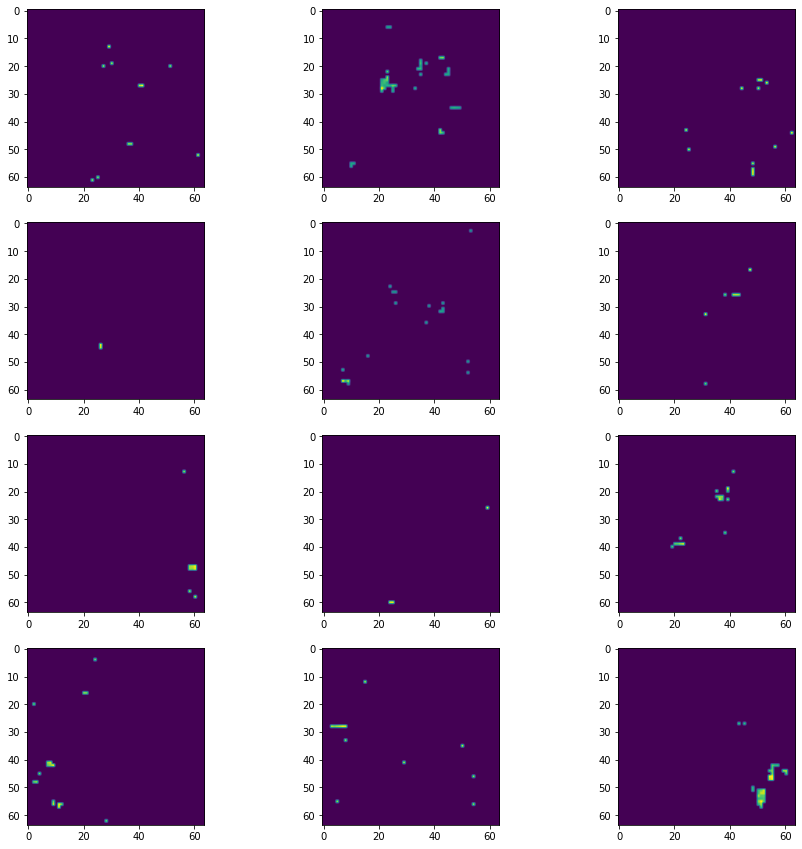

In [37]:
plot_heatmap_12_channels(occlusion_custom)

In [38]:
dl = DeepLift(model)
attribution_dl = dl.attribute(test_dataset[2]["image"].reshape((1,12,64,64)).float(), target=int(test_dataset[2]["label"].numpy()[0]))

/home/aleksandra/PycharmProjects/captum/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/aleksandra/PycharmProjects/captum/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


In [39]:
attribution_dl.min()

tensor(-0.0429, grad_fn=<MinBackward1>)

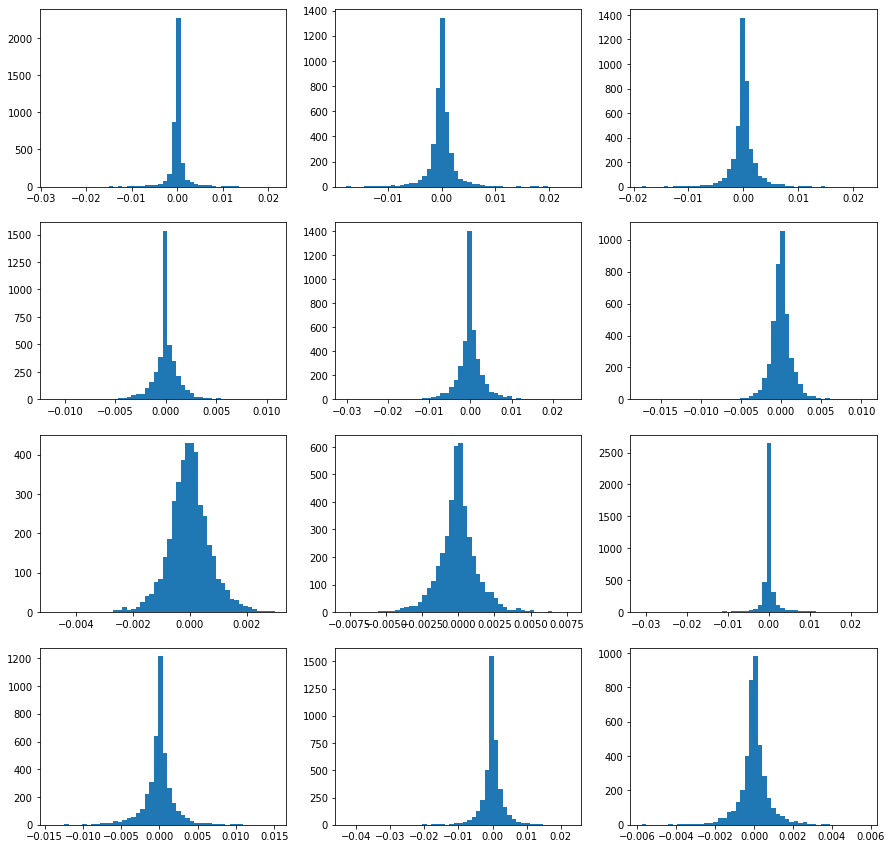

In [40]:
plot_heatmap_12_channels_hist(attribution_dl.detach().numpy()[0])

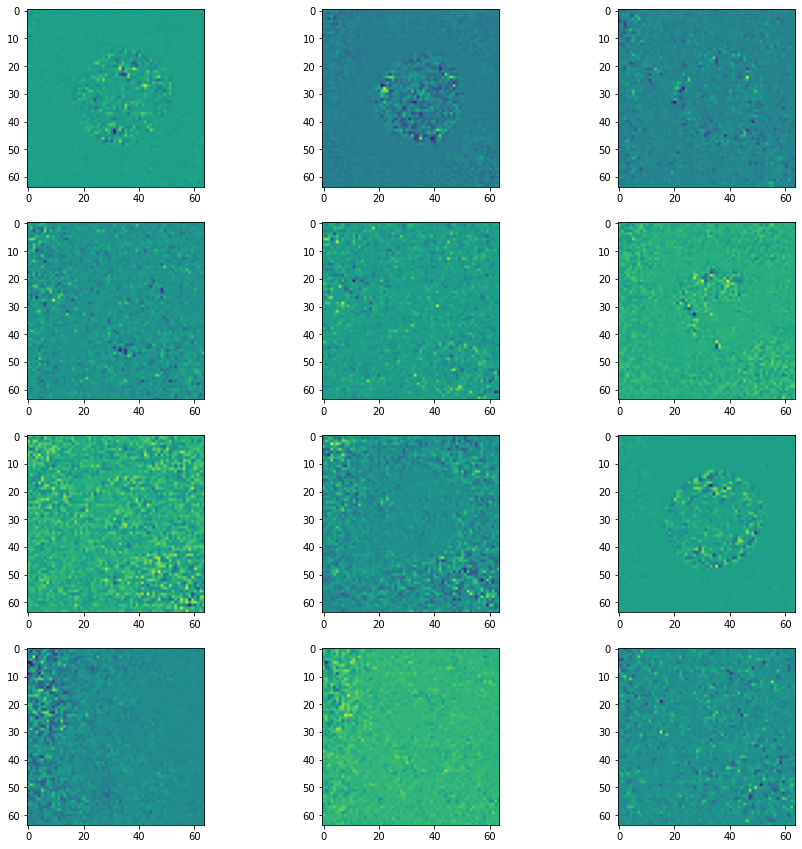

In [41]:
plot_heatmap_12_channels(attribution_dl.detach().numpy()[0])

In [42]:
(attribution_dl.max() - attribution_dl.min()) /2

tensor(0.0335, grad_fn=<DivBackward0>)

In [45]:
deepLift_threshold = torch.where(attribution_dl > torch.Tensor([0.01]), attribution_dl, torch.Tensor([0]))

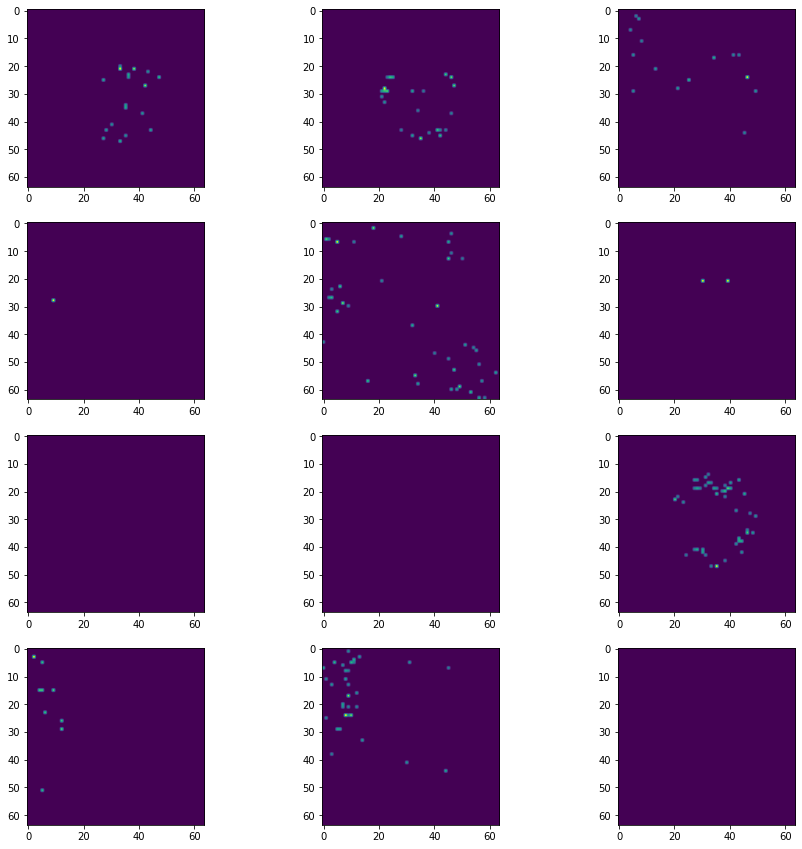

In [46]:
plot_heatmap_12_channels(deepLift_threshold.detach().numpy()[0])

In [80]:
model

ResNet(
  (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [96]:
layer_gc = LayerGradCam(model, model.layer1)

In [97]:
attr_layer_gc = layer_gc.attribute(test_dataset[2]["image"].reshape((1,12,64,64)).float(), target=int(test_dataset[2]["label"].numpy()[0]))

In [98]:
attr_layer_gc.shape

torch.Size([1, 1, 16, 16])

In [99]:
upsampled_attr = LayerAttribution.interpolate(attr_layer_gc, (64, 64))

In [100]:
upsampled_attr.shape

torch.Size([1, 1, 64, 64])

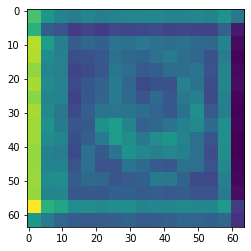

In [101]:
plt.imshow(upsampled_attr[0].detach().numpy()[0])

In [52]:
import copy
import random
def pixel_permutation_per_channel(
    model: nn.Module,
    image: torch.Tensor,
    label: Union[int, torch.Tensor],
) -> np.ndarray:

    # Get baseline probability
    baseline = model(image).detach()[0, label].item()
    im_shape = np.array(image.shape[1:])
    res = []
    im_stack = []
    for i in range(im_shape[0]):
        im = copy.deepcopy(image)
        channel_shape = im[0][i].shape
        arr = copy.deepcopy(im[0][i].flatten().detach())
        random.shuffle(arr)
        #np.random.shuffle(arr)
        im[0][i] = arr.reshape(channel_shape)
        softmax = nn.Softmax(dim=1)
        prob = softmax(model(im)).detach()[0, label].item()
        res.append({"chanel": i, "prob": prob})
        im_stack.append(im[0][i])
        #Tracer()()
    #Tracer()()
    im_stack = np.stack(im_stack, axis=0)
    #plot_heatmap_12_channels(im_stack)
    return res

In [53]:
pixel_permutation_per_channel(model, test_dataset[2]["image"].reshape((1,12,64,64)).float(), test_dataset[2]["label"].numpy()[0])

[{'chanel': 0, 'prob': 0.9894903302192688},
 {'chanel': 1, 'prob': 0.9915000796318054},
 {'chanel': 2, 'prob': 0.9913143515586853},
 {'chanel': 3, 'prob': 0.9918362498283386},
 {'chanel': 4, 'prob': 0.9911223649978638},
 {'chanel': 5, 'prob': 0.9917774200439453},
 {'chanel': 6, 'prob': 0.9918944239616394},
 {'chanel': 7, 'prob': 0.9921189546585083},
 {'chanel': 8, 'prob': 0.9931760430335999},
 {'chanel': 9, 'prob': 0.9894376993179321},
 {'chanel': 10, 'prob': 0.9931040406227112},
 {'chanel': 11, 'prob': 0.9912732243537903}]

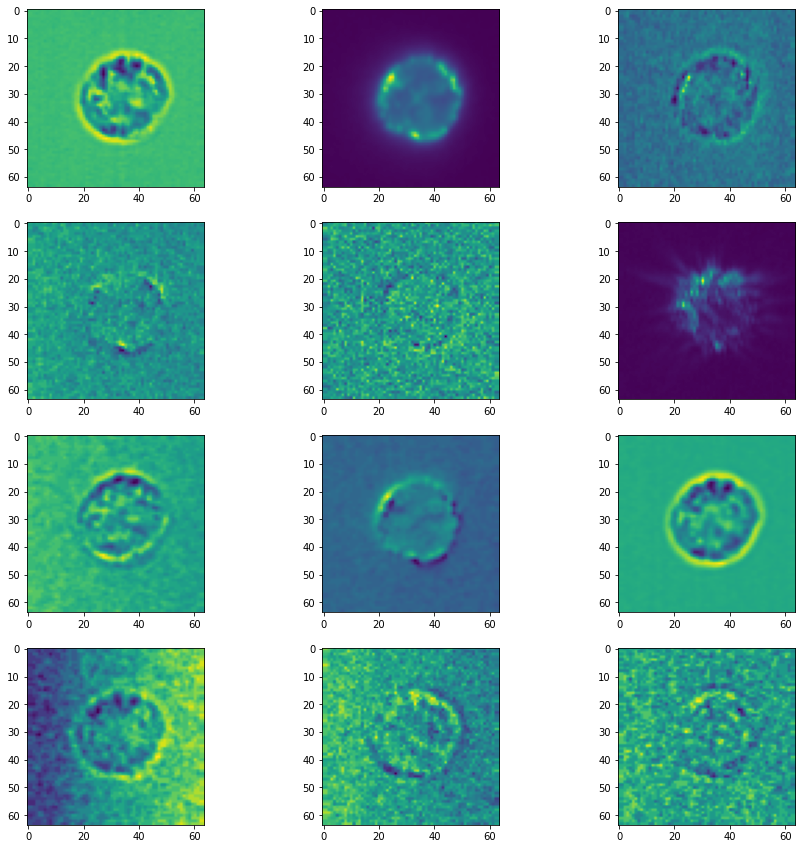

In [54]:
plot_heatmap_12_channels(test_dataset[2]["image"])

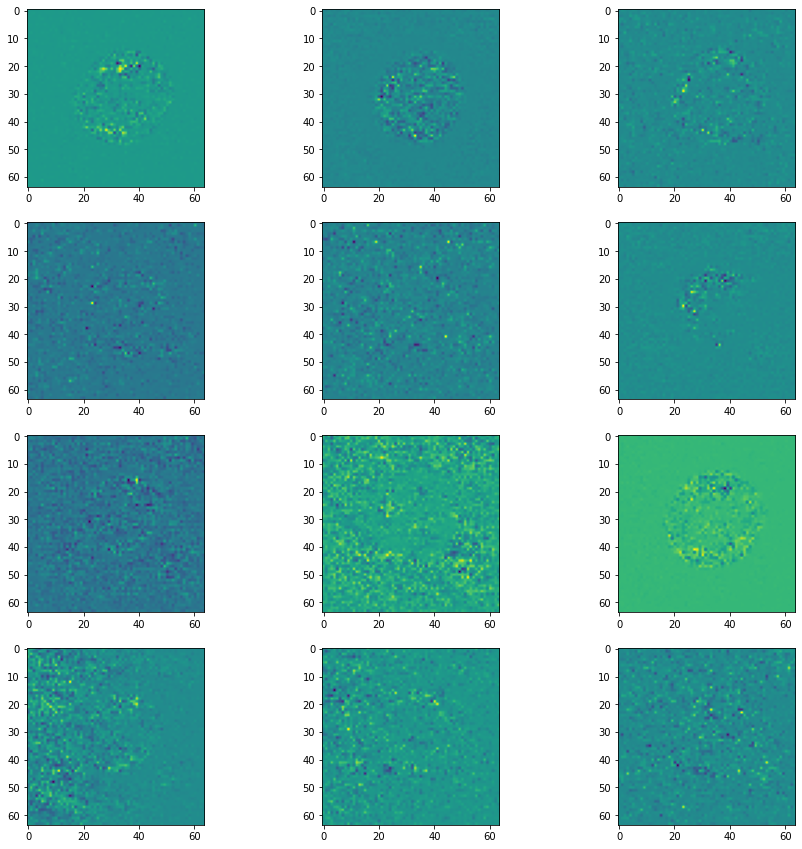

In [55]:
ig = IntegratedGradients(model)
attribution_ig = ig.attribute(test_dataset[2]["image"].reshape((1,12,64,64)).float(), target=int(test_dataset[2]["label"].numpy()[0]))
plot_heatmap_12_channels(attribution_ig.detach().numpy()[0])

In [ ]:
test_dataset[1]["image"][1,:,:]

with torch.no_grad():
    heatmaps = torch.empty(0, dtype=torch.float32, device=device)
    for data in testloader:
        indx = (data["object_number"] != -1).reshape(-1)
        if indx.sum() > 0:
            inputs, labels = data["image"][indx], data["label"][indx]
            inputs, labels = inputs.to(device), labels.to(device)     
            inputs = inputs.float()
            labels = labels.reshape(-1)
            Tracer()()
            heatmap = dl.attribute(inputs, target=labels.tolist())
            heatmaps = torch.cat((heatmaps, heatmap))

In [68]:
test_indx_short = [11066,
 9154,
 16744]

In [69]:
test_dataset =  Dataset_Generator(h5_file , test_indx_short, reshape_size = 64, means=statistics_test["mean"].div_(len(testloader)), stds=statistics_test["std"].div_(len(testloader)) )
testloader = DataLoader( test_dataset, 
                                batch_size= batch_size, 
                                shuffle=False, 
                                num_workers=1)

In [77]:
with torch.no_grad():
    for data in testloader:
        indx = (data["object_number"] != -1).reshape(-1)
        if indx.sum() > 0:
            inputs, labels = data["image"][indx], data["label"][indx]
            inputs, labels = inputs.to(device), labels.to(device)     
            inputs = inputs.float()
            labels = labels.reshape(-1)
            baselines = model(inputs).detach()[np.arange(len(labels.tolist())), labels.tolist()]
            heatmaps = dl.attribute(inputs, target=labels.tolist())
            image_size = heatmaps.shape[1]*heatmaps.shape[2]*heatmaps.shape[3]
            sorted_regions_vals, sorted_regions_ids = torch.sort(heatmaps.reshape(heatmaps.shape[0],image_size),
                                                                     dim=1, descending=True)
            inputs_flatten = copy.deepcopy(inputs.reshape(inputs.shape[0],image_size))
            for i in range(min(1000,image_size)):
                Tracer()()
                inputs_flatten[sorted_regions_ids] = 0.0

/home/aleksandra/anaconda3/envs/monai/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`
  app.launch_new_instance()


> <ipython-input-77-3b33764d61db>(17)<module>()
     13                                                                      dim=1, descending=True)
     14             inputs_flatten = copy.deepcopy(inputs.reshape(inputs.shape[0],image_size))
     15             for i in range(min(1000,image_size)):
     16                 Tracer()()
---> 17                 inputs_flatten[sorted_regions_ids] = 0.0

ipdb> inputs_flatten.shape
torch.Size([3, 49152])
ipdb> sorted_regions_ids.shape
torch.Size([3, 49152])
ipdb> sorted_regions_ids[:i]
tensor([], size=(0, 49152), dtype=torch.int64)
ipdb> i
0
ipdb> sorted_regions_ids[:0]
tensor([], size=(0, 49152), dtype=torch.int64)
ipdb> sorted_regions_ids.shape
torch.Size([3, 49152])
ipdb> sorted_regions_ids[0]
tensor([19700,  2277, 33352,  ..., 11252,  8664,   247])
ipdb> sorted_regions_ids[0:0]
tensor([], size=(0, 49152), dtype=torch.int64)
ipdb> sorted_regions_ids[0:1]
tensor([[19700,  2277, 33352,  ..., 11252,  8664,   247]])
ipdb> sorted_regions_ids[:

In [74]:
min(1000,20)

20

In [70]:
def calculate_aops(model, testloader, heatmap_fct, L = 10000):
    with torch.no_grad():
        for data in testloader:
            indx = (data["object_number"] != -1).reshape(-1)
            if indx.sum() > 0:
                inputs, labels = data["image"][indx], data["label"][indx]
                inputs, labels = inputs.to(device), labels.to(device)     
                inputs = inputs.float()
                labels = labels.reshape(-1)
                baselines = model(inputs).detach()[np.arange(len(labels.tolist())), labels.tolist()]
                heatmaps = dl.attribute(inputs, target=labels.tolist())
                image_size = heatmaps.shape[1]*heatmaps.shape[2]*heatmaps.shape[3]
                sorted_regions_vals, sorted_regions_ids = torch.sort(heatmaps.reshape(heatmaps.shape[0],image_size),
                                                                     dim=1, descending=True)
                inputs_flatten = copy.deepcopy(inputs.reshape(inputs.shape[0],image_size))
                for i in range(min(L,image_size)):
                    Tracer()()
                    inputs_flatten[sorted_regions_ids] = 0.0
    interm_sum = 0
    res = []
    for i in range(length):
        copy_arr = image_flatten.clone()
        idx = indices[:i+1]
        for j in idx:
            copy_arr[j] = 0
        prob_occl = model(copy_arr.reshape(shape)).detach()[0, label].item()
        interm_sum += baseline - prob_occl
        res.append(interm_sum / (i+1))
        #Tracer()()
    plt.bar(range(1,len(res)+1), res)
    #softmax
    return interm_sum / (length+1)

In [ ]:
def calculate_aops(model, testloader, label, heatmaps, L = 10000):
    with torch.no_grad():
        for data in testloader:
            indx = (data["object_number"] != -1).reshape(-1)
            if indx.sum() > 0:
                inputs, labels = data["image"][indx], data["label"][indx]

                inputs, labels = inputs.to(device), labels.to(device)     
                inputs = inputs.float()
                labels = labels.reshape(-1)

                baseline = model(inputs)
                _ , predicted = torch.max(outputs.data, 1)


                shape = inputs.shape
                image_flatten = inputs.flatten()
                flatten_attr = heatmap.flatten()
    #Tracer()()
    o = flatten_attr.sort(descending=True)
    #o = flatten_attr[::-1].sort()
    indices = o[1]
    if len(indices)<L:
        length = len(indices)
    else: length = L
    interm_sum = 0
    res = []
    for i in range(length):
        copy_arr = image_flatten.clone()
        idx = indices[:i+1]
        for j in idx:
            copy_arr[j] = 0
        prob_occl = model(copy_arr.reshape(shape)).detach()[0, label].item()
        interm_sum += baseline - prob_occl
        res.append(interm_sum / (i+1))
        #Tracer()()
    plt.bar(range(1,len(res)+1), res)
    #softmax
    return interm_sum / (length+1)

In [ ]:
#model